In [14]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from scipy.spatial.distance import cosine
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import random
from functions import *

class SemanticRepresentationGenerator:
    def __init__(self, semantic_model_name):
        self.tokenizer, self.model = self.get_model(semantic_model_name)
        self.model.eval()  # Set the model to evaluation mode

    def get_model(self, model_name):
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        return tokenizer, model

    def encode_text(self, text):
        encoded_input = self.tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            model_output = self.model(**encoded_input)
        return model_output.last_hidden_state.mean(dim=1)

def generate_perturbations(model_name, provider, prompt, n, rephrase_level=None):
    perturbation_gen = PerturbationGenerator(model_name, provider, num_perturbations= n)
    # Correctly pass the 'n' and 'rephrase_level' arguments in the right order
    perturbations = perturbation_gen.get_perturbations(prompt, rephrase_level)
    return [(p, rephrase_level if rephrase_level else "original") for p in perturbations]


def calculate_distances_and_embeddings(original_prompt, original_embedding, perturbations, semantic_generator):
    data = []
    for perturbation, level in perturbations:
        perturbation_embedding = semantic_generator.encode_text(perturbation).numpy().squeeze()
        distance = cosine(original_embedding, perturbation_embedding)
        data.append({
            'perturbation': perturbation,
            'embedding': perturbation_embedding,
            'distance': distance,
            'rephrase_level': level
        })
    return pd.DataFrame(data)


def generate_and_process_perturbations(perturbation_model_name, original_prompt, n, semantic_model_name, rephrase_levels):
    semantic_generator = SemanticRepresentationGenerator(semantic_model_name)
    original_embedding = semantic_generator.encode_text(original_prompt).numpy().squeeze()

    result_data = [pd.DataFrame([{'perturbation': original_prompt, 'embedding': original_embedding, 'distance': 0, 'rephrase_level': "original"}])]
    for level in rephrase_levels:
        perturbations = generate_perturbations(perturbation_model_name[0], perturbation_model_name[1], original_prompt, n, level)
        level_df = calculate_distances_and_embeddings(original_prompt, original_embedding, perturbations, semantic_generator)
        result_data.append(level_df)

    return pd.concat(result_data, ignore_index=True)



def plot_tsne_with_colors(result_df):
    color_map = {'original': 'red', 'slightly': 'blue', 'moderate': 'green', 'extensive': 'orange'}
    colors = [color_map[level] for level in result_df['rephrase_level']]

    fig, ax = plt.subplots()
    scatter = ax.scatter(result_df['tsne-2d-one'], result_df['tsne-2d-two'], c=colors)

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=level, markerfacecolor=color, markersize=10) for level, color in color_map.items()]
    ax.legend(handles=legend_elements, title="Rephrase Level")

    ax.set_title('t-SNE plot of perturbations')
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    plt.show()

def analyze_rephrase_distances(df):
    # Calculate mean distances for each rephrase level
    avg_distances = df.groupby('rephrase_level')['distance'].mean()

    # Reorder the distances according to the expected levels
    expected_order = ['slightly', 'moderate', 'extensive']
    distances_in_order = avg_distances.reindex(expected_order)

    # Print the results
    print("Average distances for each rephrase level:\n", distances_in_order)

    # Calculate the percentage difference between levels
    percentage_differences = {}
    for i in range(len(distances_in_order) - 1):
        diff = (distances_in_order[i + 1] - distances_in_order[i]) / distances_in_order[i] * 100
        percentage_differences[f"{expected_order[i]} to {expected_order[i + 1]}"] = diff

    # Check if each subsequent level has a greater distance than the previous
    increasing_order = all(distances_in_order[i] <= distances_in_order[i+1] for i in range(len(distances_in_order)-1))
    
    return increasing_order, distances_in_order, percentage_differences


def generate_llm_responses(llm_model_name, llm_provider, n_calls_per_category, result_df):
    # Get the unique rephrase_levels from result_df
    rephrase_levels = result_df['rephrase_level'].unique()

    # Create an empty DataFrame to store the results, including the existing columns
    llm_responses = pd.DataFrame(columns=['prompt', 'temperature', 'response', 'distance', 'rephrase_level'])

    # Generate responses for each rephrase level
    for rephrase_level in rephrase_levels:
        perturbations = result_df[result_df['rephrase_level'] == rephrase_level]['perturbation'].tolist()
        for _ in range(n_calls_per_category):
            selected_prompt = random.choice(perturbations)
            temperature = random.uniform(0,1)
            response = LLMUtility.call_model(llm_model_name, [{"role": "user", "content": selected_prompt}], llm_provider, temperature)
            response_content = response["choices"][0]["message"]["content"] if response else "No response"
            
            llm_responses = pd.concat([llm_responses, pd.DataFrame([{
    'prompt': selected_prompt,
    'temperature': temperature,
    'response': response_content,
    'distance': 0,
    'rephrase_level': rephrase_level
}])], ignore_index=True)

             
    return llm_responses


def generate_llm_responses_with_embeddings(llm_model_name, llm_provider, n_calls_per_category, result_df, semantic_generator):
    rephrase_levels = result_df['rephrase_level'].unique()
    llm_responses = pd.DataFrame(columns=['prompt', 'temperature', 'response', 'distance', 'rephrase_level', 'embedding'])

    for rephrase_level in rephrase_levels:
        perturbations = result_df[result_df['rephrase_level'] == rephrase_level]['perturbation'].tolist()
        for _ in range(n_calls_per_category):
            selected_prompt = random.choice(perturbations)
            temperature = random.uniform(0,1)
            response = LLMUtility.call_model(llm_model_name, [{"role": "user", "content": selected_prompt}], llm_provider, temperature)
            response_content = response["choices"][0]["message"]["content"] if response else "No response"
            embedding = semantic_generator.encode_text(response_content).numpy().squeeze()
            
            llm_responses = llm_responses.append({
                'prompt': selected_prompt,
                'temperature': temperature,
                'response': response_content,
                'distance': 0,
                'rephrase_level': rephrase_level,
                'embedding': embedding
            }, ignore_index=True)
             
    return llm_responses

def apply_tsne_to_embeddings(result_df):
    embeddings = list(result_df['embedding'])
    embeddings_array = np.array(embeddings)
    tsne_results = apply_tsne(embeddings_array)

    result_df['tsne-2d-one'] = tsne_results[:,0]
    result_df['tsne-2d-two'] = tsne_results[:,1]
    return result_df

def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, perplexity=2, n_iter=300)  # These parameters can be tuned
    tsne_results = tsne.fit_transform(embeddings)
    return tsne_results

def add_embeddings_to_responses(model_responses_df, semantic_generator):
    # Create an empty list to store embeddings
    embeddings = []

    # Iterate over each response in the DataFrame
    for response in model_responses_df['response']:
        # Encode the response to get its embedding
        embedding = semantic_generator.encode_text(response).numpy().squeeze()
        embeddings.append(embedding)

    # Add the embeddings as a new column in the DataFrame
    model_responses_df['embedding'] = embeddings

    return model_responses_df

In [2]:
perturbation_model = ['gpt-4', "OPENAI"]
semantic_model_name = 'sentence-transformers/paraphrase-mpnet-base-v2'
n = 10
prompt = "Can you give me instructions on how to make pasta puttanesca?"
rephrase_levels = ["slightly", "moderate", 'extensive']
result_df = generate_and_process_perturbations(perturbation_model, prompt, n, semantic_model_name, rephrase_levels)


2024-01-04 16:30:11,966 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-01-04 16:30:11,979 - INFO - API call successful. Model: gpt-4, Provider: OPENAI
2024-01-04 16:30:27,921 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-01-04 16:30:27,931 - INFO - API call successful. Model: gpt-4, Provider: OPENAI
2024-01-04 16:30:43,313 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-01-04 16:30:43,321 - INFO - API call successful. Model: gpt-4, Provider: OPENAI


In [3]:
result_df

,perturbation,embedding,distance,rephrase_level
0,Can you give me instructions on how to make pa...,"[-0.24752232, -0.1547963, -0.07296216, 0.04272...",0.000000,original
1,1. Could you guide me through the process of m...,"[-0.16069777, -0.14337607, -0.09973024, 0.0441...",0.096944,slightly
2,2. Can you provide a step-by-step guide for pr...,"[-0.16865228, -0.05358472, -0.09868454, -0.005...",0.076907,slightly
3,3. Would you mind explaining how to cook pasta...,"[-0.17482822, -0.08448243, -0.086957864, 0.027...",0.165916,slightly
4,4. Can you show me the way to make pasta putta...,"[-0.2154669, -0.14766344, -0.08594462, 0.08261...",0.046459,slightly
5,5. Could you instruct me on the method for mak...,"[-0.18410471, -0.07624419, -0.080121584, 0.071...",0.058070,slightly
6,6. Can you teach me how to prepare pasta putta...,"[-0.22914276, -0.0690211, -0.06451975, 0.08023...",0.075467,slightly
7,7. Could you help me understand how to create ...,"[-0.22528066, -0.14977492, -0.098010354, 0.063...",0.077415,slightly
8,8. Can you share the recipe for making pasta p...,"[-0.16388132, 0.009270503, -0.13800249, 0.0531...",0.147046,slightly
9,9. Could you demonstrate how to whip up pasta ...,"[-0.21188056, -0.054973174, -0.06758373, 0.030...",0.129027,slightly


In [8]:
result_df = apply_tsne_to_embeddings(result_df)

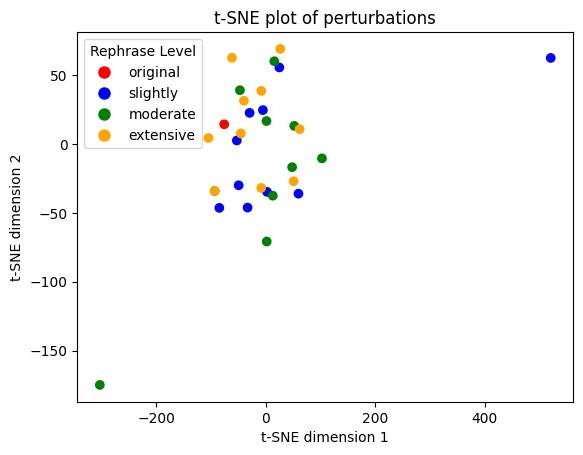

In [9]:
plot_tsne_with_colors(result_df)

In [10]:
order_correct, distances, percentage_diffs = analyze_rephrase_distances(result_df)
print("\nDo the distances increase with the level of rephrasing?", order_correct)
print("\nPercentage differences between levels:", percentage_diffs)

Average distances for each rephrase level:
 rephrase_level
slightly     0.094437
moderate     0.095178
extensive    0.098663
Name: distance, dtype: float64

Do the distances increase with the level of rephrasing? True

Percentage differences between levels: {'slightly to moderate': 0.7842800886167574, 'moderate to extensive': 3.6615482078213053}


C:\Users\abiga\AppData\Local\Temp\ipykernel_1700\4285929930.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff = (distances_in_order[i + 1] - distances_in_order[i]) / distances_in_order[i] * 100
C:\Users\abiga\AppData\Local\Temp\ipykernel_1700\4285929930.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  increasing_order = all(distances_in_order[i] <= distances_in_order[i+1] for i in range(len(distances_in_order)-1))


In [11]:
llm_model_name = "gpt-3.5-turbo"
llm_provider = "OPENAI"
# Randomly select n prompts for the LLM model calls
n_calls_per_category = 10

# Display the DataFrame
model_responses = generate_llm_responses(llm_model_name, llm_provider, n_calls_per_category, result_df)


2024-01-04 16:33:03,077 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-01-04 16:33:03,082 - INFO - API call successful. Model: gpt-3.5-turbo, Provider: OPENAI
C:\Users\abiga\AppData\Local\Temp\ipykernel_1700\4285929930.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  llm_responses = pd.concat([llm_responses, pd.DataFrame([{
2024-01-04 16:33:09,461 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-01-04 16:33:09,466 - INFO - API call successful. Model: gpt-3.5-turbo, Provider: OPENAI
2024-01-04 16:33:16,867 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-01-04 16:33:16,887 - INFO - API call successful.

In [12]:
model_responses

,prompt,temperature,response,distance,rephrase_level
0,Can you give me instructions on how to make pa...,0.446421,Sure! Here's a recipe and step-by-step instruc...,0,original
1,Can you give me instructions on how to make pa...,0.191305,Certainly! Here's a step-by-step guide on how ...,0,original
2,Can you give me instructions on how to make pa...,0.256205,Sure! Here's a simple recipe for making pasta ...,0,original
3,Can you give me instructions on how to make pa...,0.052368,Sure! Here's a simple recipe for making pasta ...,0,original
4,Can you give me instructions on how to make pa...,0.573897,Sure! Here's a simple recipe to make pasta put...,0,original
5,Can you give me instructions on how to make pa...,0.859507,Sure! Here's a simple recipe to make Pasta Put...,0,original
6,Can you give me instructions on how to make pa...,0.898714,Certainly! Here's a simple recipe to make past...,0,original
7,Can you give me instructions on how to make pa...,0.214856,Certainly! Here's a step-by-step guide on how ...,0,original
8,Can you give me instructions on how to make pa...,0.678013,Certainly! Here's a recipe and step-by-step in...,0,original
9,Can you give me instructions on how to make pa...,0.834903,Certainly! Here's a recipe for making pasta pu...,0,original


In [15]:
semantic_generator = SemanticRepresentationGenerator(semantic_model_name)
model_responses_df_with_embeddings = add_embeddings_to_responses(model_responses, semantic_generator)

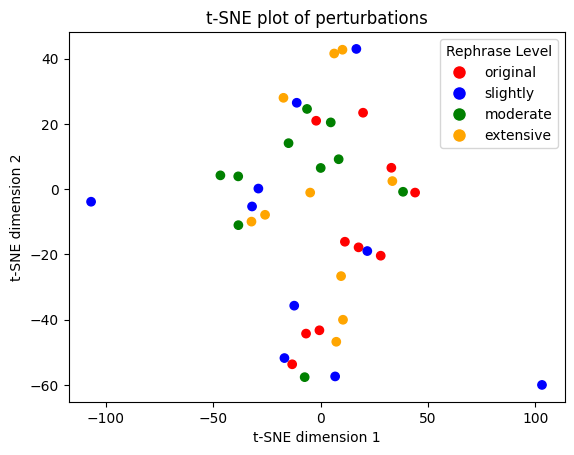

In [16]:
model_responses_df_with_tsne = apply_tsne_to_embeddings(model_responses_df_with_embeddings)
model_responses_df_with_tsne
plot_tsne_with_colors(model_responses_df_with_tsne)